In [1]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.60
Loading CCF brain structure data...
Loading time: 0.01
Loading flat_map ...
Loading time: 3.59


In [2]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get cell list

In [4]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "LGd"
target = "VISp"
tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(target))
print([nmt.bs.id_to_name(i) for i in tid])
distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']


['VISp', 'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b']


In [5]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Manually_corrected_soma_region'].isin([group])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata = metadata[['brain', 'creline']]
nlist = metadata.index.tolist()

metadata.head()


,brain,creline
17302_00039,17302,Tnnt1
17302_00040,17302,Tnnt1
17302_00041,17302,Tnnt1
17302_00048,17302,Tnnt1
17302_00049,17302,Tnnt1


In [6]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [7]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00039,7508.825,3264.750,3309.475
17302_00040,7807.400,3186.925,3528.725
17302_00041,7828.450,3074.025,3610.625
17302_00048,7283.675,2852.050,3534.600
17302_00049,7621.600,2909.775,3616.600


## Axon

In [8]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
# cc = ca.loc[cc]
# cc

In [9]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
        axon_dict.update({i:cswc})
        axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]

print(len(nlist), len(nlist_selected))

17545_00095:	0.60mm
18463_00057:	0.00mm
78 76


## distance soma v.s. axon

In [10]:
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



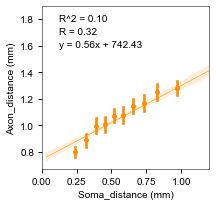

In [11]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0,1.2))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_"+group+"_v2.pickle", 'wb'))

## Axon overlaps

Merging child region VISp into region VISp
Merging child region VISp1 into region VISp
Merging child region VISp2/3 into region VISp
Merging child region VISp4 into region VISp
Merging child region VISp5 into region VISp
Merging child region VISp6a into region VISp
Merging child region VISp6b into region VISp
Loading time for region VISp : 5.98


(7175.0, 10850.0) (0.0, 2800.0) (1550.0, 4850.0)
x steps:	49
y steps:	37
z steps:	44
17302_00039 17302_00040
0.0030835564257766235


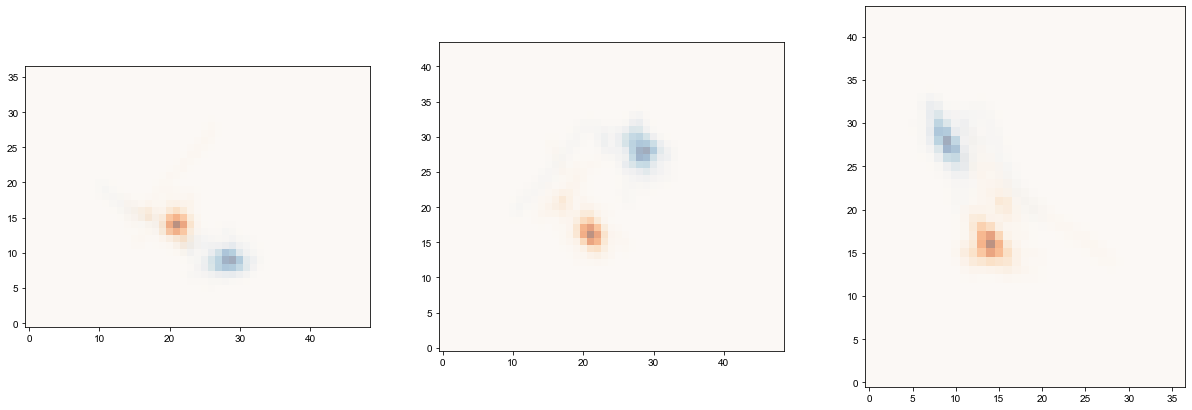

In [12]:
# Get subvolumn
region_id = nmt.bs.name_to_id(target)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [13]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

In [14]:
overlap_df

,17302_00039,17302_00040,17302_00041,17302_00048,17302_00049,17302_00066,17302_00080,17302_00117,17302_00118,17302_00119,...,18465_00113,18465_00114,18465_00115,18465_00116,18465_00117,18465_00119,18465_00136,18465_00140,18465_00141,18465_00148
17302_00039,1,0.00308356,0.00049775,2.27353e-10,2.58431e-12,6.95001e-21,0.000687534,0.171611,0.0690563,5.71014e-13,...,9.41794e-05,0.110303,0.0551642,0.00786279,0.291813,0.000143382,0.0117118,0.00348972,0.0274556,0.0331238
17302_00040,0.00308356,1,0.00189342,2.37635e-15,8.26956e-05,0.000380353,0.0178318,0.0244593,0.000126674,0.00118821,...,0.000566295,0.0127022,2.62939e-05,0.206348,0.000477662,0.219902,0.179368,0.0337735,0.0530238,0.010196
17302_00041,0.00049775,0.00189342,1,1.44828e-05,0.0506816,0.0114254,6.15848e-11,0.000158888,0.0394616,0.0252471,...,0.124125,0.0299468,0.00644086,0.0390795,0.00138617,0.000475645,3.10491e-06,8.65902e-11,0.000101667,1.39974e-06
17302_00048,2.27353e-10,2.37635e-15,1.44828e-05,1,8.48275e-05,9.65258e-05,5.08954e-48,6.25437e-11,0.00174828,2.58767e-09,...,0.0181726,5.83818e-07,0.0412846,1.67933e-13,0.0152112,7.791e-31,4.08287e-33,1.12926e-46,4.2491e-22,5.70942e-05
17302_00049,2.58431e-12,8.26956e-05,0.0506816,8.48275e-05,1,0.200013,5.95169e-37,2.67617e-16,0.00438183,0.00523419,...,0.105841,0.000158456,0.000604316,6.42831e-06,7.1762e-05,9.69156e-19,2.82605e-25,1.16436e-31,2.54474e-13,9.00913e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00119,0.000143382,0.219902,0.000475645,7.791e-31,9.69156e-19,3.7619e-22,0.129438,0.000756134,1.73703e-07,6.92962e-06,...,6.16779e-14,0.000874561,1.412e-07,0.0743617,1.17947e-08,1,0.384684,0.0518006,0.059228,0.00104673
18465_00136,0.0117118,0.179368,3.10491e-06,4.08287e-33,2.82605e-25,6.23646e-25,0.132029,0.00563318,8.10545e-05,1.35192e-09,...,6.21899e-16,0.00717981,0.00128003,0.015118,0.000681828,0.384684,1,0.0676424,0.0775502,0.00706659
18465_00140,0.00348972,0.0337735,8.65902e-11,1.12926e-46,1.16436e-31,1.92814e-28,0.0380284,0.00892842,3.23206e-10,1.83628e-19,...,3.89805e-24,1.09072e-05,1.96239e-06,2.08619e-05,1.05608e-07,0.0518006,0.0676424,1,0.170358,0.0435227
18465_00141,0.0274556,0.0530238,0.000101667,4.2491e-22,2.54474e-13,1.74091e-11,0.102629,0.0718408,9.8172e-06,2.34365e-08,...,3.82253e-09,0.00274435,0.000629027,0.0029339,0.000677637,0.059228,0.0775502,0.170358,1,0.0831156


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



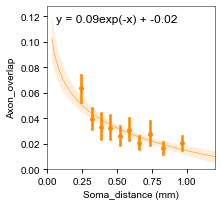

In [15]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0,1.2))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_"+group+"_v2.pickle", 'wb'))